In [353]:
'''
code drafts; feel free to skip to the introduction and come back here for reference
'''
import matplotlib.pyplot as plt
import numpy as np

from functools import lru_cache


def compute_d1(x, strike, r, sigma, t, **kwargs):
    return (np.log(x/strike) + (r + 0.5 * sigma**2)*t)/(sigma*np.sqrt(t))

def compute_d2(x, strike, r, sigma, t, **kwargs):
    return (np.log(x/strike) + (r - 0.5 * sigma**2)*t)/(sigma*np.sqrt(t))

def compute_delta(x, strike, r, sigma, t, option, **kwargs):
    d1 = compute_d1(x, strike, r, sigma, t)
    d2 = d1 - sigma * np.sqrt(t)
    
    if option == 'call':
        return np.exp(-t)*norm.cdf(d1)
    
    if option == 'put':
        return -np.exp(-t)*norm.cdf(-d1)

def compute_vega(x, strike, r, sigma, t, option, **kwargs):
    d1 = compute_d1(x, strike, r, sigma, t)
    return x * norm.pdf(d1) * np.sqrt(t)

def compute_rho(x, strike, r, sigma, t, option, **kwargs):
    d1 = compute_d1(x, strike, r, sigma, t)
    d2 = d1 - sigma * np.sqrt(t)
    
    if option == 'call':
        return strike * t * np.exp(-r*t)*norm.cdf(d2)
    
    if option == 'put':
        return -strike * t * np.exp(-r*t)*norm.cdf(-d2)
    
def compute_theta(x, strike, r, sigma, t, option, **kwargs):
    d1 = compute_d1(x, strike, r, sigma, t)
    d2 = d1 - sigma * np.sqrt(t)
    
    if option == 'call':
        return -(x, norm.pdf(d1)*sigma / (2*np.sqrt(t))) - r*strike*np.exp(-r*t)*norm.cdf(d2)
    
    if option == 'put':
        return -(x, norm.pdf(d1)*sigma / (2*np.sqrt(t))) + r*strike*np.exp(-r*t)*norm.cdf(-d2)
    
def compute_gamma(x, strike, r, sigma, t, option, **kwargs):
    d1 = compute_d1(x, strike, r, sigma, t)
    return norm.pdf(d1) / (x* sigma * np.sqrt(t))

def bs_analytical(x, strike, t, r, sigma, option, **kwargs):
    d1 = compute_d1(x, strike, r, sigma, t)
    d2 = compute_d2(x, strike, r, sigma, t)
    if option == 'call':
        return x * norm.cdf(d1) - strike * np.exp(-r * t) * norm.cdf(d2)
    if option == 'put':
        return strike * np.exp(-r * t) * norm.cdf(-d2) - x * norm.cdf(-d1)

# Introduction
Heat PDE equations have been well studied, as well as numerical schemes that can consistently solve them. In this study, we intend to apply those learnings to a separate field, in particular the Black Scholes PDE in finance. This report will be structured as follows:
* **[Background](#Background)**
* **[Exploration](#Exploration)**
* **[Analysis](#Analysis)**
* **[Discussion](#Discussion)**
* **Conclusion**

Our ultimate goal is to build a Python package that can reliably price options using finite difference methods based on the Black Scholes PDE. We will first approach the problem conceptually based on the foundation of heat equations. In the **Background**, we recall the derivation of the diffusion equation and compare that to the Black Scholes equation. The intuitions drawn will be important in the later sections as they will serve as a mental guide on verifying the correctness and direction of the study (or simply said, to have something to refer back to if the numerical method do not work out). We will make an initial naive numerical attempt in the **Exploration** so that we can "fail" fast. While making use from these initial mistakes, we put our initial round of learnings into the **Analysis**, where we will define our schemes more rigorously and design algorithm logic with better confidence. The implementation will be included as a separate Python package submission, in which its functionality, consistency, stability, and convergence will be discussed in **Discussion**. We will summarize value this study may contribute as well as the areas of improvements in the **Conclusion**.

# Background
## The Classic Heat Equation
PDEs for heat equations describe physical properties in how energy is transferred within a thermodynamic system. For those who study physics, the most simple mental model is to imagine a 1-dimensional insolated metal rod of some length $L$ on the x-axis, such that it allows the energy to flow from areas of higher temperatures to those of lower temperatures across some time $t$. Navigating through both time and space changes the computational results of the correct temperature on the rod. 

![title](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRDc0ozC7zaexvrhF1KzwVZMNbKpw3Eqk4DKj7kkUSfNXWPmhU3WXUb85kRzlY8MXEBjzs&usqp=CAU) 

Suppose we let $u(\tau, x)$ denote the temperature along the line $(0, L)$ at time $\tau$ where $x$ is a point on the line. Also, suppose there is already an initial temperature distribution at $\tau=0$ given by $u(0, x)$. Physics tells us as $\tau$ increases, the temperature dissipates from warmer to cooler areas. To derive the heat equation, we first establish an equality that holds according to the conservation of energy. 
$$
\frac{\partial Q}{\partial \tau} + \nabla \cdot F = 0
$$
where $Q$ is the amount of heat at each point and $F$ is the vector field giving the flow of heat. 
We obtain $Q$ from the physical properties of the metal:
$$
Q=\rho cu
$$
where $\rho$ is the density and $c$ is the specific heat capacity. 

$F$ on the other hand is proportional to the negative gradient of the temperature, because the rate of at which the energy flows from the warmer area to the cooler area is proportional to the temperature difference. So it holds the general form:
$$
F = -k \nabla u
$$
where $k$ is the thermal conductivity. In the 1d metal rod, this reduces to:
$$
F= -k \frac{\partial u}{\partial x} x
$$
Substituting and taking derivatives, we get:
$$
\rho c \frac{\partial u}{\partial \tau} + \nabla \cdot (-k \frac{\partial u}{\partial x}x) = 0
$$
There we arrive at the general form of the diffusion equation:
$$
\begin{equation} \label{eq:diffusion} \tag{1}
\frac{\partial u}{\partial \tau} = \frac{\partial ^2 u}{\partial x^2}
\end{equation}
$$
We can interpret the derived diffusion equation $(1)$ by claiming the temporal change of temperature at a certain point depends on the spatial change of the temperature gradient at this point. In layman terms, the rate at which the temperature will change over time is determined by the difference of the ratio of the temperature difference between the left and right of the point (2nd derivative). Because the gradient vanishes as time increases, there would less and less tendency for the gradient to cause any heat flow. Therefore we eventually reach an equilibrium state as time evolves where the gradient vanishes, in which $\frac{\partial u}{\partial \tau}$ becomes $0$. Let's remember this interpretation for now. 

![title](https://i.imgur.com/WN35yk6.png) 

## From Physical to Financial
In contrast, if supposedly physical properties were to stem from the nature, the financial world is driven by the decisions of actors within the market and with its rules created artificially. Yet in a nobel-prize-winning equation - the Black-Scholes PDE - we can observe a similar existence of the temporal and spatial terms (note the LHS):
$$
\begin{equation} \label{eq:bs} \tag{2}
\frac{\partial V}{\partial t} + \frac{1}{2} \sigma^2 S^2 \frac{\partial ^2 V}{\partial S^2} = rV - rS \frac{\partial V}{\partial S}
\end{equation}
$$
Let's first define and derive the PDE to understand what it is trying to represent financially. We let $V$ be the financial derivative of an underlying instrument $S$ we are attempting to value. We also include $\sigma$ and $r$ that describe the volatility (standard deviation) of the underlying and the risk-free interest rate respectively. 

Let's also assume that the financial derivative is an option. In simplicity, we define an option as a right for the holder to exercise a contract, for which the seller (holder) is (not) obliged to trade the underlying. A call option is one which gives the holder the right to buy the underlying for a certain price. Simiarly, a put option is one which gives the holder the right to sell. 

Imagine we are setting up a portfolio $\Pi$ ourselves and we utilize an option as a tool to hedge against risk. For simplicity, let's assume $\Pi$ is only comprised of one option $V$ and an amount $\Delta$ of underlying stock $S$ such that $\Pi$ is riskless, meaning it is not sensitive to the changes in the price of the stock. Then the portfolio value at time $t$ can be given by:
$$
\Pi(t) = V(t) + \Delta S(t)
$$
Because the value of the portfolio is determined solely by the values of both financial instruments, then $d \Pi = d V + \Delta d S$. Suppose the underlying price follows a geometric Brownian motion given by the stochastic differential equation $dS = S(\sigma d W + \mu dt)$, the option evolves as follows by Ito's lemma:
$$
d \Pi = \left( \frac{\partial V}{\partial t} + \mu S \frac{\partial V}{\partial S} + \frac{1}{2} \sigma ^2 S^2 \frac{\partial ^2 V}{\partial S ^2} + \Delta \mu S \right) dt + \left( \sigma S \frac{\partial V}{\partial S} + \Delta \sigma S \right) dW
$$
Accounting for the price insensitivity feature ie. $\Delta = -\frac{\partial V}{\partial S}$, the second term involving $dW$ becomes $0$. The portfolio process simplifies to
$$
d \Pi = \left ( \frac{\partial V}{\partial t} + \frac{1}{2} \sigma ^2 S^2 \frac{\partial ^2 V}{\partial S^2} \right ) dt
$$
Counting in two ways, $\Pi$ also earns the risk free rate $r$, this suggests another diffusion of the riskless portofolio in which $d \Pi = r \Pi dt$. Putting the two equality as one we get:
$$
\begin{aligned}
d \Pi &= r \Pi dt \\
\left ( \frac{\partial V}{\partial t} + \frac{1}{2} \sigma ^2 S^2 \frac{\partial ^2 V}{\partial S^2} \right ) dt &= r \left ( V - \frac{\partial V}{\partial S} S \right) dt \\
\frac{\partial V}{\partial t} + \frac{1}{2} \sigma^2 S^2 \frac{\partial ^2 V}{\partial S^2} &= rV - rS \frac{\partial V}{\partial S}
\end{aligned}
$$
What does it mean? Let's start with the RHS that has fewer partial derivative terms. Basically it returns the riskless return by holding a long position in the option and a short position consisting of $\frac{\partial V}{\partial S}$ or $-\Delta$ of the underlying. In other words, $\Delta$ is also known as the hedge ratio and holds values $0<|\Delta|<1$. One property of $\Delta$ is that it becomes wider if the difference between the underlying and the option is narrower (basically the underlying behaves just like the option in terms of price). 

On the LHS, we have the only temporal variable in the equation $\frac{\partial V}{\partial t}$ summed by some multiple of the spatial variable $\frac{\partial ^2 V}{\partial S^2}$. The former term also known as $\theta$ is typically negative for an option, intuitively because the value of the option should decrease if there is less time to exercise it. The latter term also known as $\Gamma$ is the derivative of $\Delta$. Recall from calculus class when we learn about derivatives of an accelerating and decelerating car in terms of displacement, velocity, and acceleration. Now this $\Gamma$ value is analagous to that upward convexity curve in which its optimal value is also the inflection point of $\Delta$. Thus it is the measurement of the option's convexity with respect to the stock, which is typically positive because we expect to gain from holding on to the option. 

Putting both sides into picture, we can think of the gains from $\Gamma$ offsets the loss from $\theta$ and because there is time value in money, the offset difference is the return at the riskless rate. 

## Correspondence?
So now bringing eq $(1)$ and eq $(2)$ into the picture, what do we observe? Most notably 
$$\frac{\partial u}{\partial \tau} - \frac{\partial ^2 u}{\partial x^2} = \ldots$$ compared to the $$\frac{\partial V}{\partial t} +  \frac{\partial ^2 V}{\partial S^2} = \ldots$$

As we discussed earlier, $\theta$ is typically negative and $\Gamma$ is typically positive. So essentially when taking the difference between the two partial derivatives from the heat equation, the result is $0$. On the other hand, the difference between that of the Black Scholes PDE yields returns! Sounds profitable by the equation's face value doesn't it. 

Let's think about it more deeply. The rate $\frac{\partial ^2 u}{\partial x^2}$ at which heat flows through the metal rod is fastest as the temperature gradient is the widest. Similarly, $\Gamma$ is smallest when the option is deep out-of-the-money and in-the-money and highest when it gets near-the-money. In-the-money (ITM), at-the-money (ATM), and out-of-the-money (OTM) is a way of describing the intrinsic value of the option (ranked from positive intrinsic value to $0$). For simplicity, if the gap between the strike price of an option is the widest from the underlying price, the option becomes most "profitable" and carries the most positive intrinsic value. As the gap closes, the value drops to $0$. As the gap widens again further in the opposite direction, the value still remains $0$ (because no one would exercise the option at a loss) but the $\Delta$ is now very insensitive to the underlying price. 

What's interesting about comparing the two spatial 2nd derivative? For the heat equation, this term is largest when the temperature gradient is the highest. On the contrary, the convexity peaks when the strike price and the underlying price are closest to each other. So the two relationships are opposite of each other. 

That goes for the definition and real-world interpretation of the two PDEs. The intention of our study is to draw on what we previously learned about from heat PDEs and how to numerically solve to be able to apply the same onto Black Scholes PDE. This section contains some important background as we will now move into some analysis and breaking down the Black Scholes PDE into numerical schemes. Having a strong understanding between the two would help us identify what can potentially go wrong in our exploration. It will also help us know what to expect out of the solutions and what to visualize on a graph. 

## Option Types and Analytical Solution
There are many types of options. We will start with one that is numerically basic - the European option - which stipulates the execution to its expiration date. This naturally yields a boundary condition at the terminal time because the value of the option would simply be:
$$
\begin{aligned}
C(S, T) &= \max\{S-K, 0\} \\
P(S, T) &= \max\{K-S, 0\}
\end{aligned}
$$
for a call and and a put respectively. Graphically it looks like:

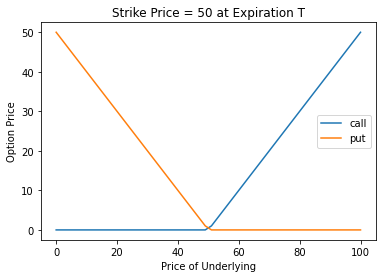

In [365]:
params = {
    'strike': 50, 
}
S = np.linspace(0, 100)
C = np.maximum(S - params['strike'], np.zeros_like(S))
P = np.maximum(params['strike'] - S, np.zeros_like(S))
plt.plot(S, C, label='call')
plt.plot(S, P, label='put')
plt.legend()
plt.title(f'Strike Price = {params["strike"]} at Expiration T')
plt.xlabel('Price of Underlying')
plt.ylabel('Option Price')
plt.show()


Although it may sound counterintuitive, it is easier numerically to think of this terminal condition as the initial condition because our goal is to be able to price the option to the current time $t$. In essence we perform a change-of-variable transformation in which time is flipped. For a call option, we have (same applies for put):
$$
\begin{aligned}
\tau &= T - t \in [0, T] \\
x &= \ln\left(\frac{S}{K}\right) \in \mathbb{R}
\end{aligned}
$$
This yields a new equation:
$$
Z(x, \tau) = V(K e^x, T-\tau)
$$
Thus the PDE transform into:
$$
\frac{\partial Z}{\partial \tau} - \frac{1}{2} \sigma^2 \frac{\partial ^2 Z}{\partial x^2} + \left( \frac{\sigma ^2}{2}-r \right) \frac{\partial Z}{\partial x} + rZ = 0
$$

We make another transformation:
$$
u(x, \tau) = e^{\alpha x + \beta \tau}Z(x, \tau)
$$
where we pick some $\alpha, \beta \in \mathbb{R}$ such that $u$ is the heat equation. For the PDE, we have:
$$
\frac{\partial u}{\partial \tau} - \frac{\sigma^2}{2}\frac{\partial ^2 u}{\partial x ^2} + A \frac{\partial u}{\partial x} + Bu = 0
$$
where
$$
A = \alpha \sigma ^2 + \frac{\sigma^2}{2} - r, \quad B = (1+\alpha)r - \beta - \frac{\alpha^2\sigma^2+\alpha \sigma^2}{2}
$$

To simplify into the diffusion equation, we set

$$
\alpha = \frac{r}{\sigma^2} - \frac{1}{2}, \quad \beta = \frac{r}{2} + \frac{\sigma^2}{8} + \frac{r^2}{2\sigma^2}
$$

This makes $A=B=0$ so the PDE now looks like:
$$
\frac{\partial u}{\partial \tau} = \frac{1}{2} \sigma^2 \frac{\partial ^2 u}{\partial x^2}
$$

We can apply [Green's Function](https://www.physics.uci.edu/~silverma/bseqn/bs.pdf) to solve the PDE:

$$
u(x, \tau) = \frac{1}{\sqrt{2\sigma^2\pi\tau}} \int_{-\infty}^{\infty}e^{-\frac{(x-s)^2}{2\sigma^2 \tau}}u(s, 0) ds
$$

This gives us an integral we can work with so that we can work backwards towards the original equation:

$$
V(S, t) \Longleftarrow Z(x, \tau) \Longleftarrow u(x, \tau)
$$

Note that we flipped time so the terminal condition $V(S, T) = \max(S-K, 0)$ becomes the initial condition of $u$:
$$
\begin{aligned}
u(x,0) &= e^{\alpha x} V(S, T) \\
&=\begin{cases}
          e^{\alpha x}(S-K) \quad &\text{if} \, x > 0 \\
          0 \quad &  \, \text{otherwise} \\
     \end{cases} 
\end{aligned}
$$

Substituting back:

$$
\begin{aligned}
u(x, \tau) &= \frac{1}{\sqrt{2\sigma^2\pi\tau}} \int_{0}^{\infty}e^{-\frac{(x-s)^2}{2\sigma^2 \tau}}e^{\alpha s} (S-K) ds \\
&= K e^{x+\frac{1}{2}\sigma^2 \tau} \mathcal{N}(d_1) - K \mathcal{N}(d_2)
\end{aligned}
$$

where $\mathcal{N}(\cdot)$ is the standard normal CDF and

$$
\begin{aligned}
d_1 &= \frac{1}{\sigma \sqrt{\tau}} \left[ \left( x+\frac{1}{2}\sigma^2 \tau\right)+\frac{1}{2}\sigma^2 \tau\right]\\
d_2 &= \frac{1}{\sigma \sqrt{\tau}} \left[ \left( x+\frac{1}{2}\sigma^2 \tau\right)-\frac{1}{2}\sigma^2 \tau\right]
\end{aligned}
$$

Finally we get back at:

$$
V(S, t) = S\cdot \mathcal{N}(d_1) - Ke^{-r(T-t)}\cdot\mathcal{N}(d_2)
$$

<ipython-input-782-3986182ca862>:5: RuntimeWarning: divide by zero encountered in true_divide
  return (np.log(x/strike) + (r + 0.5 * sigma**2)*(T-t))/(sigma*np.sqrt((T-t)))
<ipython-input-782-3986182ca862>:8: RuntimeWarning: divide by zero encountered in true_divide
  return (np.log(x/strike) + (r - 0.5 * sigma**2)*(T-t))/(sigma*np.sqrt((T-t)))


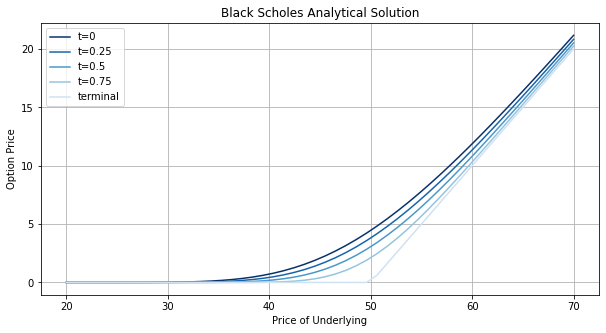

In [782]:
import matplotlib as mpl
from scipy.stats import norm

def compute_d1(x, strike, r, sigma, t, T, **kwargs):
    return (np.log(x/strike) + (r + 0.5 * sigma**2)*(T-t))/(sigma*np.sqrt((T-t)))

def compute_d2(x, strike, r, sigma, t, T, **kwargs):
    return (np.log(x/strike) + (r - 0.5 * sigma**2)*(T-t))/(sigma*np.sqrt((T-t)))

def bs_analytical(x, strike, t, T, r, sigma, option, **kwargs):
    d1 = compute_d1(x, strike, r, sigma, t, T)
    d2 = compute_d2(x, strike, r, sigma, t, T)
    if option == 'call':
        return x * norm.cdf(d1) - strike * np.exp(-r * (T-t)) * norm.cdf(d2)
    if option == 'put':
        return strike * np.exp(-r * (T-t)) * norm.cdf(-d2) - x * norm.cdf(-d1)
params['T'] = 1
params['r'] = 0.02
params['sigma'] = 0.2
params['option'] = 'call'
S = np.linspace(20, 70)

t_values = [0, 0.25, 0.5, 0.75, 1]
levels = mpl.colors.Normalize(vmin=0, vmax=len(t_values))
cmap = mpl.cm.ScalarMappable(norm=levels, cmap=mpl.cm.Blues)
plt.rcParams["figure.figsize"] = (10,5)
for i, t in enumerate(t_values):
    params['t'] = t
    label = f't={t}' if t != 1 else 'terminal'
    V = bs_analytical(x=S, **params)
    plt.plot(S, V, label=label, c=cmap.to_rgba(len(t_values) - i))
plt.xlabel('Price of Underlying')
plt.ylabel('Option Price')
plt.title('Black Scholes Analytical Solution')
plt.legend()
plt.grid()
plt.show()

# Exploration

This is a first attempt to construct a numerical scheme. We will start with explicit Euler and forward differences. We should draw quick observations from this first run in order to know what we should pay the most attention to when implementing the PDE solver package. 

Given the original Black Scholes PDE,
$$
\frac{\partial V}{\partial t} + \frac{1}{2} \sigma^2 S^2 \frac{\partial ^2 V}{\partial S^2} = rV - rS \frac{\partial V}{\partial S}
$$
we will rewrite it as
$$
U_t = - \frac{\sigma^2 x^2}{2} U_{xx} - rxU_x+ru
$$
where we represent the option price $V$ as the temperature variable $U$ and the underlying price $S$ transforms into the spatial variable $x$.

For the boundary condition, we can rely on the fact that we know what the option price be at the expiration date based on what the put/call contract imposes. 

Discretizing the 1st derivatives using first order forward in time and space and discretizing the 2nd derivative using centered in space (FTFS), we arrive at the following:
$$
\begin{aligned}
\frac{U_j^{n+1} - U_j^n}{\Delta t} &= \frac{-\sigma^2x^2}{2}\left [\frac{U_{j+1}^n - 2U_j^n+U_{j-1}^n}{\Delta x^2}\right] - rx_j \left[\frac{U_{j+1}^n-U_j^n}{\Delta x} \right] + rU_j^n \\
U_j^{n+1} &= U_j^n+\Delta t \left(\frac{-\sigma^2x^2}{2}\left[\frac{U_{j+1}^n - 2U_j^n+U_{j-1}^n}{\Delta x^2}\right] - rx_j \left[\frac{U_{j+1}^n-U_j^n}{\Delta x}\right] + rU_j^n\right)
\end{aligned}
$$
We flip time and let $t=T-\tau$ just like the derivation of the Black Schole analytical solution derivation. This flips signs in the terms that contain a time derivative
$$
\begin{aligned}
U_\tau &= \frac{\sigma^2 x^2}{2} U_{xx} + rxU_x - ru \\
\frac{U_j^{n+1} - U_j^n}{\Delta t} &= \frac{\sigma^2x^2}{2}\left[\frac{U_{j+1}^n - 2U_j^n+U_{j-1}^n}{\Delta x^2}\right] + rx_j \left[\frac{U_{j+1}^n-U_j^n}{\Delta x}\right] - rU_j^n \\
U_j^{n+1} &= U_j^n+\Delta \tau \left(\frac{\sigma^2x^2}{2}\left[\frac{U_{j+1}^n - 2U_j^n+U_{j-1}^n}{\Delta x^2}\right] + rx_j \left[\frac{U_{j+1}^n-U_j^n}{\Delta x}\right] - rU_j^n\right)
\end{aligned}
$$
Setting up a system for the vectors of unknowns $\vec{U}$, we arrive at the following matrix update scheme:
$$
\vec{U}^{n+1} =
\begin{bmatrix}
\alpha_1 & \beta_1 & 0 & 0 & 0 \\
\gamma_2 & \alpha_2 & \beta_2 & 0 & 0 \\
& \ddots & \ddots & \ddots & \\
0 & 0 & \gamma_{m-1} & \alpha_{m-1} & \beta_{m-1}\\
0 & 0 & 0 & \gamma_m & \alpha_m
\end{bmatrix}\vec{U}^{n}
$$
where
$$
\alpha_j = 1 - \frac{\Delta \tau \sigma ^2 x_j^2}{\Delta x^2} - \frac{\Delta \tau  r x_j}{\Delta x} - r \Delta \tau , \quad
\beta_j = \frac{\Delta \tau \sigma^2 x_j^2}{2\Delta x^2} + \frac{\Delta \tau rx_j}{\Delta x}, \quad
\gamma_j = \frac{\Delta \tau \sigma ^2 x_j^2}{2\Delta x^2} 
$$
Doing the same two other schemes so we can compare. (FTBS) forward in time and backward in space
$$
U_j^{n+1} = U_j^n+\Delta \tau \left(\frac{\sigma^2x^2}{2}\left[\frac{U_{j+1}^n - 2U_j^n+U_{j-1}^n}{\Delta x^2}\right] + rx_j \left[\frac{U_{j}^n-U_{j-1}^n}{\Delta x}\right] - rU_j^n\right)
$$
We get the matrix:
$$
\vec{U}^{n+1} =
\begin{bmatrix}
\alpha_1 & \beta_1 & 0 & 0 & 0 \\
\gamma_2 & \alpha_2 & \beta_2 & 0 & 0 \\
 & \ddots & \ddots & \ddots & \\
0 & 0 & \gamma_{m-1} & \alpha_{m-1} & \beta_{m-1}\\
0 & 0 & 0 & \gamma_m & \alpha_m
\end{bmatrix}\vec{U}^{n}
$$
where
$$
\alpha_j = 1 - \frac{\Delta \tau \sigma ^2 x_j^2}{\Delta x^2} + \frac{\Delta \tau r x_j}{\Delta x} - r \Delta \tau, \quad
\beta_j = \frac{\Delta \tau \sigma^2 x_j^2}{2\Delta x^2}, \quad
\gamma_j = \frac{\Delta \tau \sigma ^2 x_j^2}{2\Delta x^2} - \frac{\Delta \tau rx_j}{\Delta x}
$$
(FTCS) forward in time and centered in space. Let $x_i = a+\Delta x i, i=0, 1, 2, \ldots, N$ and $\Delta x = \frac{b-a}{N}$
$$
U_j^{n+1} = U_j^n+\Delta \tau \left(\frac{\sigma^2x_j^2}{2}\left[\frac{U_{j+1}^n - 2U_j^n+U_{j-1}^n}{\Delta x^2}\right] + rx_j \left[\frac{U_{j+1}^n-U_{j-1}^n}{2\Delta x}\right] - rU_j^n\right)
$$
We get the matrix:
$$
\vec{U}^{n+1} =
\begin{bmatrix}
\alpha_1 & \beta_1 & 0 & 0 & 0 \\
\gamma_2 & \alpha_2 & \beta_2 & 0 & 0 \\
 & \ddots & \ddots & \ddots & \\
0 & 0 & \gamma_{N-2} & \alpha_{N-2} & \beta_{N-2}\\
0 & 0 & 0 & \gamma_{N-1} & \alpha_{N-1}
\end{bmatrix}\vec{U}^{n} + \vec{F}^n \Delta t \\
$$
where
$$
\alpha_j = 1 - \frac{\Delta \tau \sigma ^2 x_j^2}{\Delta x^2} - r \Delta \tau, \quad
\beta_j = \frac{\Delta \tau \sigma^2 x_j^2}{2\Delta x^2}  + \frac{\Delta \tau rx_j}{2\Delta x}, \quad
\gamma_j = \frac{\Delta \tau \sigma ^2 x_j^2}{2\Delta x^2} - \frac{\Delta \tau rx_j}{2\Delta x} \\
\vec{F}^n = [f_1^n, 0, \ldots, 0, f_{N-1}^n]^T, \quad
f_1^n = \left( \sigma^2 \frac{x_1^2}{\Delta x^2} - r \frac{x_1}{2 \Delta x} \right ) L(t^n), \quad
f_{N-1}^n = \left( \sigma^2 \frac{x_{N-1}^2}{\Delta x^2} + r \frac{x_{N-1}}{2 \Delta x} \right ) R(t^n)
$$
We now implement the initial versions of these three derivative approximations

In [640]:
def bs_ftfs_v0(a, b, r, sigma, M, N, t_final, strike, boundary=False, **kwargs):
    '''
    FTFS Forward in Time, Forward in Space
    '''
    tmp = M
    M, N = N, tmp
    U = np.zeros((N, M))
    delta_x = (b-a) / (M-1)
    delta_t = t_final / (N-1)
    
    X = np.linspace(a, b, M)
    if boundary:
        T = np.linspace(0, t_final, N)
        def g(x):
            def _g(t):
                return x - strike * np.exp(-r * t)
            return _g
        U[:,-1] = np.vectorize(g(X[-1]))(T)
    alpha = np.array([1 - delta_t * sigma ** 2 * x_j ** 2 / delta_x ** 2 - delta_t * r * x_j / delta_x - r * delta_t for x_j in X])
    beta = np.array([delta_t * sigma**2 * x_j ** 2 / 2 / delta_x**2 + delta_t * r * x_j / delta_x for x_j in X[1:]])
    gamma = np.array([delta_t * sigma ** 2 * x_j**2 / 2 / delta_x ** 2 for x_j in X[:-1]])
    
    d1 = np.diag(alpha)
    d2 = np.diag(beta, 1)
    d3 = np.diag(gamma, -1)
    A = d1 + d2 + d3
    
    U[0,:] = np.array([max(0, price-strike) for price in np.linspace(a,b,M)])
    for i in range(N-1):
        U[i+1,:] = A.dot(U[i,:])
        
    return X, U

def bs_ftbs_v0(a, b, r, sigma, M, N, t_final, strike, boundary=False, **kwargs):
    '''
    FTBS Forward in Time, Backward in Space
    '''
    tmp = M
    M, N = N, tmp
    U = np.zeros((N, M))
    delta_x = (b-a) / (M-1)
    delta_t = t_final / (N-1)
    
    X = np.linspace(a, b, M)
    if boundary:
        T = np.linspace(0, t_final, n)
        def g(x):
            def _g(t):
                return x - strike * np.exp(-r * t)
            return _g
        U[:,-1] = np.vectorize(g(X[-1]))(T)
    alpha = np.array([1 - delta_t * sigma ** 2 * x_j ** 2 / delta_x ** 2 + delta_t * r * x_j / delta_x - r * delta_t for x_j in X])
    beta = np.array([delta_t * sigma**2 * x_j ** 2 / 2 / delta_x**2 for x_j in X[1:]])
    gamma = np.array([delta_t * sigma ** 2 * x_j**2 / 2 / delta_x ** 2 - delta_t * r * x_j / delta_x for x_j in X[:-1]])
    
    d1 = np.diag(alpha)
    d2 = np.diag(beta, 1)
    d3 = np.diag(gamma, -1)
    A = d1 + d2 + d3
    
    U[0,:] = np.array([max(0, price-strike) for price in np.linspace(a,b,M)])
    for i in range(N-1):
        U[i+1,:] = A.dot(U[i,:])
        if boundary:
            U[i+1,-1] = g(X[-1], T[i+1])
        
    return X, U

def bs_ftcs_v0(a, b, r, sigma, M, N, t_final, strike, adaptive_x=False, **kwargs):
    '''
    forward in time (forward Euler), centered in space
    '''
    # x = -L, i.e., price close to zero
    def L(tau):
        return 0

    # x = L, i.e., price close to infinity
    def R(tau, x):
        return x - strike * np.exp(-r * tau)

    # initial condition 
    def u0(x):
        return max(x-strike, 0)

    delta_x = (b-a) / N
    delta_t = t_final/M
    U = np.zeros((N + 1, M + 1))

    X = np.arange(a, b + delta_x, delta_x)
    if adaptive_x:
        a_to_strike = strike - np.geomspace(1, strike - a, int(N/2))
        strike_to_b = strike + np.geomspace(1, b - strike, int(N/2))
        X = np.concatenate((a_to_strike[::-1], [strike], strike_to_b))
    T = np.arange(0, t_final + delta_t, delta_t)

    @lru_cache
    def A():
        alpha = [1-delta_t * sigma ** 2 * x**2 / (X[i+1]-X[i]) ** 2 - r * delta_t for i,x in enumerate(X[1:-1])]
        beta = [delta_t * sigma**2 * x**2 / 2 / (X[i+1]-X[i]) **2 + delta_t * r * x / 2/ (X[i+1]-X[i]) for i,x in enumerate(X[1:-2])]
        gamma = [delta_t * sigma**2 * x**2 / 2 / (X[i+2]-X[i+1]) **2 - delta_t * r * x / 2/ (X[i+2]-X[i+1]) for i,x in enumerate(X[2:-1])]
        d1 = np.diag(beta, 1)
        d2 = np.diag(alpha, 0)
        d3 = np.diag(gamma, -1)
        return d1+d2+d3

    U[:,0] = np.vectorize(u0)(X)
    for i in range(M):
        F = np.zeros((N-1, 1))
        F[0] = (sigma**2 * X[1] **2 / (X[1] - X[0])**2 - r * X[1] / 2/ (X[1] - X[0])) * L(T[i])
        F[-1] = (sigma**2 * X[-2] **2 / (X[-1] - X[-2])**2 + r * X[-2] / 2/(X[-1] - X[-2])) * R(T[i], X[-1])
        U[1:-1, i+1] = np.reshape(A() @ np.reshape(U[1:-1,i], (N-1,1)) + F * delta_t, (N-1))
        U[-1,i+1] = R(T[i+1], X[-1])
    return X, T, U

Let's see how the first attempt play out:

<ipython-input-388-c12e60ba37a4>:5: RuntimeWarning: divide by zero encountered in log
  return (np.log(x/strike) + (r + 0.5 * sigma**2)*(T-t))/(sigma*np.sqrt((T-t)))
<ipython-input-388-c12e60ba37a4>:8: RuntimeWarning: divide by zero encountered in log
  return (np.log(x/strike) + (r - 0.5 * sigma**2)*(T-t))/(sigma*np.sqrt((T-t)))


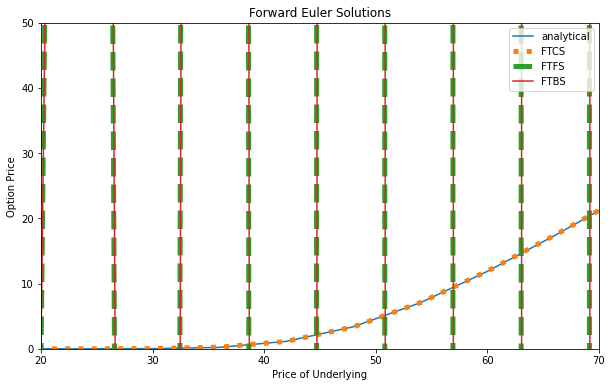

In [645]:
params = {'a':0, 'b':300, 'r':0.02, 'strike':50, 'sigma':0.2, 'M':50, 'N':50, 't_final':1, 'T':1, 't':0, 'option':'call'}
fig, ax = plt.subplots(figsize=(10, 6))
X, T, U = bs_ftcs_v0(**params)
ax.plot(X, bs_analytical(x=X, **params), label='analytical')
ax.plot(X, U[:,-1], label='FTCS', linestyle=':', linewidth=5)
X, U = bs_ftfs_v0(**params)
ax.plot(X, U[:,-1], label='FTFS', linestyle='--', linewidth=5)
X, U = bs_ftbs_v0(**params)
ax.plot(X, U[:,-1], label='FTBS')
ax.legend()
ax.set_xlim(20, 70)
ax.set_ylim(0, 50)
plt.xlabel('Price of Underlying')
plt.ylabel('Option Price')
plt.title('Forward Euler Solutions')
plt.show()

Both FTFS and FTBS did not play out nicely. Possibly due to the boundary conditions which we can fix next if we want to. Perhaps let's try one more idea to see if we can make more efficient use of the $\tau$ and $x$ space, meaning if we can use less grid points but still maintain the level of accuracy. That might make our study more interesting. To be comprehensive, let's also turn the knob for some of the parameters to look for any interesting observations. 

<ipython-input-388-c12e60ba37a4>:5: RuntimeWarning: divide by zero encountered in log
  return (np.log(x/strike) + (r + 0.5 * sigma**2)*(T-t))/(sigma*np.sqrt((T-t)))
<ipython-input-388-c12e60ba37a4>:8: RuntimeWarning: divide by zero encountered in log
  return (np.log(x/strike) + (r - 0.5 * sigma**2)*(T-t))/(sigma*np.sqrt((T-t)))


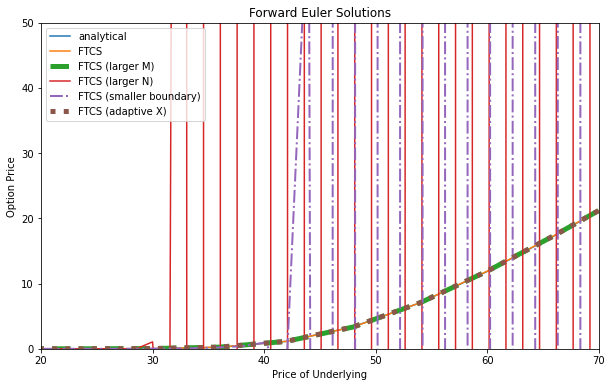

In [646]:
def override(params, **kwargs):
    new_params = params.copy()
    new_params.update(kwargs)
    return new_params

fig, ax = plt.subplots(figsize=(10, 6))
X, T, U = bs_ftcs_v0(**params)
ax.plot(X, bs_analytical(x=X, **params), label='analytical')
ax.plot(X, U[:,-1], label='FTCS')
X, T, U = bs_ftcs_v0(**override(params, M=200))
ax.plot(X, U[:,-1], label='FTCS (larger M)', linestyle='--', linewidth=5)
X, T, U = bs_ftcs_v0(**override(params, N=200))
ax.plot(X, U[:,-1], label='FTCS (larger N)')
X, T, U = bs_ftcs_v0(**override(params, b=100))
ax.plot(X, U[:,-1], label='FTCS (smaller boundary)', linestyle='-.', linewidth=2)
X, T, U = bs_ftcs_v0(**override(params, adaptive_x=True, b=70, N=20))
ax.plot(X, U[:,-1], label='FTCS (adaptive X)', linestyle=':', linewidth=5)
ax.legend()
ax.set_xlim(20, 70)
ax.set_ylim(0, 50)
plt.xlabel('Price of Underlying')
plt.ylabel('Option Price')
plt.title('Forward Euler Solutions')
plt.show()

Qualitatively we can make the following observations:
1. The central difference method is more stable; we can try combinations of other difference methods such as forward and backward for both time and space respectively
2. Boundary conditions within the numerical scheme play a crucial role in stability. The reason FTFS and FTBS methods for not being stable can be partly due to the boundary conditions. We may rethink specifying boundary conditions between Dirichlet vs. Neumann
3. The number of spatial grid points are more sensitive than the number of time grid points
4. The upper bound in space $X_{max}$ must be sufficiently large for convergence, eg. if the strike price is $50$, $X_{max}$ must be at least 3 to 4 times of that
5. The adaptive scheme where the $\Delta x$ steps are geometrically smaller near the strike price and further apart towards the boundaries may allow for less number of grid points and a smaller $X_{max}$ value (ie. more efficient). Same can potentially hold for $\Delta t$ if we can identify regions where the derivative is more sensitive. 
6. Explicit methods may be not too stable overall; maybe consider other parabolic methods such as implicit and Crank Nicolson

We will take these into considerations when implementing our PDE solver package. What we should aim for is that the solver can pass the verifications at a quantitative level, ie. it is more robust torwards a spectrum of values within the parameters. 
# Analysis
## The Grid
We now define our finite difference methods more formally from its principles and sketch out their relations with the Black Scholes PDE. Let's start with the grid:

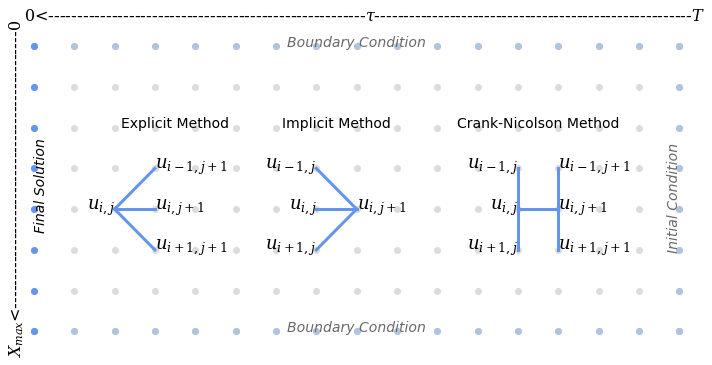

In [773]:
%matplotlib inline
plt.figure(figsize=(12,6))
c = 'lightsteelblue'
points = np.arange(0, 17, 1)
xs, ys = np.meshgrid(points, points)
plt.scatter(xs, ys, color='gainsboro')
plt.text(8, 0, 'Boundary Condition', horizontalalignment='center', fontsize=14, style='italic', color='dimgrey')
plt.text(8, 7, 'Boundary Condition', horizontalalignment='center', fontsize=14, style='italic', color='dimgrey')
plt.scatter(xs[[0, 7]], ys[[0, 7]], c=c)
plt.text(15.7, 5, 'Initial Condition', rotation='vertical', fontsize=14, style='italic', color='dimgrey')
plt.scatter(xs[:, -1], ys[:, -1], c=c)
plt.text(0, 4.5, 'Final Solution', rotation='vertical', fontsize=14, style='italic')
c = 'cornflowerblue'
plt.scatter(xs[:, 0], ys[:, 0], c=c)
plt.axis([-0.1, 16.5, -0.5, 7.5])
plt.title(r'$0$<-------------------------------------------------------$\tau$-------------------------------------------------------$T$', fontsize=16)
plt.ylabel(r'$X_{max}$<------------------------------------------------$0$', fontsize=16)
ax = plt.gca()
ax.invert_yaxis()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
plt.rcParams["mathtext.fontset"] = "dejavuserif"

f = {'i': 4, 'j': 2}
plt.plot([f['j'], f['j']+1], [f['i'], f['i']-1], '-', c=c, linewidth=3)
plt.plot([f['j'], f['j']+1], [f['i'], f['i']], '-', c=c, linewidth=3)
plt.plot([f['j'], f['j']+1], [f['i'], f['i']+1], '-', c=c, linewidth=3)
plt.text(f['j']+1.5, f['i']-2.0, 'Explicit Method', horizontalalignment='center', fontsize=14)
plt.text(f['j'], f['i'], '$u_{i, j}$', horizontalalignment='right', fontsize=18)
plt.text(f['j']+1, f['i']-1, '$u_{i-1, j+1}$', horizontalalignment='left', fontsize=18)
plt.text(f['j']+1, f['i'], '$u_{i, j+1}$', horizontalalignment='left', fontsize=18)
plt.text(f['j']+1, f['i']+1, '$u_{i+1, j+1}$', horizontalalignment='left', fontsize=18)

f = {'i': 4, 'j': 7}
plt.plot([f['j']+1, f['j']], [f['i'], f['i']-1], '-', c=c, linewidth=3)
plt.plot([f['j']+1, f['j']], [f['i'], f['i']], '-', c=c, linewidth=3)
plt.plot([f['j']+1, f['j']], [f['i'], f['i']+1], '-', c=c, linewidth=3)
plt.text(f['j']+0.5, f['i']-2.0, 'Implicit Method', horizontalalignment='center', fontsize=14)
plt.text(f['j']+1, f['i'], '$u_{i, j+1}$', horizontalalignment='left', fontsize=18)
plt.text(f['j'], f['i']-1, '$u_{i-1, j}$', horizontalalignment='right', fontsize=18)
plt.text(f['j'], f['i'], '$u_{i, j}$', horizontalalignment='right', fontsize=18)
plt.text(f['j'], f['i']+1, '$u_{i+1, j}$', horizontalalignment='right', fontsize=18)

f = {'i': 4, 'j': 12}
plt.plot([f['j'], f['j']+1], [f['i'], f['i']], '-', c=c, linewidth=3)
plt.plot([f['j'], f['j']], [f['i']-1, f['i']+1], '-', c=c, linewidth=3)
plt.plot([f['j']+1, f['j']+1], [f['i']-1, f['i']+1], '-', c=c, linewidth=3)
plt.text(f['j']+0.5, f['i']-2.0, 'Crank-Nicolson Method', horizontalalignment='center', fontsize=14)
plt.text(f['j'], f['i']-1, r'$u_{i-1, j}$', horizontalalignment='right', fontsize=18)
plt.text(f['j'], f['i'], r'$u_{i, j}$', horizontalalignment='right', fontsize=18)
plt.text(f['j'], f['i']+1, r'$u_{i+1, j}$', horizontalalignment='right', fontsize=18)
plt.text(f['j']+1, f['i']-1, r'$u_{i-1, j+1}$', horizontalalignment='left', fontsize=18)
plt.text(f['j']+1, f['i'], r'$u_{i, j+1}$', horizontalalignment='left', fontsize=18)
plt.text(f['j']+1, f['i']+1, r'$u_{i+1, j+1}$', horizontalalignment='left', fontsize=18)

plt.show()

The above illustrates the $M \times N$ grid $U$ we will use for the finite difference methods and how each method performs its approximation on the grid. There are four regions which we labeled as the initial condition (maturity at $T$), the boundary conditions for which the $x$ underlying price can take place, and the final solution for the current time $t=0$ or $\tau=T$. The initial condition has a trivial setup where the x values will be the maximum of $0$ (do not exercise) or the positive difference between the strike price and the underlying. For the following matrix notations, we will use $i\in M$ for space and $j\in N$ for time.

## Boundary Condition
The boundary condition is slightly more trickier but still an important construct in the numerical scheme. If we can establish a sensible bound, that may minimize the error and prevent instability. We naively picked a bound based on $u$ in the exploration, which followed the Dirichlet Condition. The Dirichlet boundary condition specifies the values along the boundary of the domain. An alternative is to impose a Neumann boundary condition, which specifies the values of the derivative applied at the boundary of the domain. The former is more sensitive to the $X_max$ value we pick and we have observed that we need to be more generous with the $X_max$ value to reach convergence. If we can find a way to accurately discretize the derivatives, the latter condition might be more natural and yield better results. To sketch out in equations, the Dirichlet boundary conditions will look like:
$$
\begin{aligned}
u(0, \tau)&=\begin{cases}
          0 \quad &\text{for call option} \\
          Ke^{-r\tau} \quad &  \text{for put option} \\
     \end{cases} \\
u(X_{max}, \tau) &= \begin{cases}
          X_{max}-Ke^{-r \tau} \quad &\text{for call option} \\
          0 \quad &  \text{for put option} \\
     \end{cases} 
\end{aligned}
$$
where the Neumann boundary conditions will look like
$$
\begin{aligned}
\frac{\partial^2 u}{\partial x^2}(\Delta x^2, \tau) = \frac{\partial^2 u}{\partial x^2}((N-1)\Delta x^2, \tau) = 0
\end{aligned}
$$
As the Neumann boundary conditions are more subject to the derivatives, we should also consider the choices for the derivative approximations.
## Approximation Schemes

\begin{equation}
  \tag{Forward Difference}
  \frac{\partial u}{\partial x} \approx \frac{u_{i+1, j}- u_{i,j}}{\Delta x}, \quad \frac{\partial u}{\partial \tau} \approx \frac{u_{i, j+1}- u_{i,j}}{\Delta \tau}
\end{equation}

\begin{equation}
  \tag{Backward Difference}
  \frac{\partial u}{\partial x} \approx \frac{u_{i, j}- u_{i-1,j}}{\Delta x}, \quad \frac{\partial u}{\partial \tau} \approx \frac{u_{i, j}- u_{i,j-1}}{\Delta \tau}
\end{equation}

\begin{equation}
  \tag{Central Difference}
  \frac{\partial u}{\partial x} \approx \frac{u_{i+1, j}- u_{i-1,j}}{2\Delta x}, \quad \frac{\partial u}{\partial \tau} \approx \frac{u_{i, j+1}- u_{i,j-1}}{2\Delta \tau}
\end{equation}

\begin{equation}
  \tag{2nd Derivative Difference}
  \frac{\partial ^2 u}{\partial x^2} \approx \frac{u_{i+1, j} -2u_{i,j} + u_{i-1,j}}{\Delta x ^2}
\end{equation}

Note that the first two differences are 1st order accurate and the last two differences are 2nd order accurate. Therefore, this may motivate us to prefer the central difference for the price space $x$, especially if we want to pick the Neumann boundary condition (central difference is a more natural and friendlier choice). For the time steps $\tau$, both forward and backward differences may still perform well enough based on the finding in the exploration. 
## Discretization
We now perform the same discretization using the same metholodogy as before, but this time also with the Neumann boundary conditions. For the three finite difference methods, we get the three matrix forms:
$$
\begin{equation}
  \tag{Explicit Method}
\vec{U}^{j-1} =
\begin{bmatrix}
\alpha_1 + 2\gamma_1& \beta_1-\gamma_1 & 0 & \ldots & 0 \\
\gamma_2 & \alpha_2 & \beta_2 & \ldots & 0 \\
0 & \gamma_3 & \alpha_3 & \ldots & 0 \\
\vdots & \vdots & \vdots & \ddots & \beta_{M-2}\\
0 & 0 & 0 & \gamma_{M-1}-\beta_{M-1} & \alpha_{M-1} + 2\beta_{M-1}
\end{bmatrix}\vec{U}^{j}
\end{equation} \\
\alpha_i = 1 - \Delta t \cdot (\sigma^2 i^2 + r) , \quad
\beta_i = \frac{\Delta t \cdot (ri + \sigma^2 i)}{2}, \quad
\gamma_i = \frac{\Delta t \cdot (\sigma^2 i - ri)}{2}
$$


$$
\begin{equation}
  \tag{Implicit Method}
\vec{U}^{j+1} =
\begin{bmatrix}
\alpha_1 + 2\gamma_1 & \beta_1-\gamma_1 & 0 & \ldots & 0 \\
\gamma_2 & \alpha_2 & \beta_2 & \ldots & 0 \\
0 & \gamma_3 & \alpha_3 & \ldots & 0 \\
\vdots & \vdots & \vdots & \ddots & \beta_{M-2}\\
0 & 0 & 0 & \gamma_{M-1}-\beta_{M-1} & \alpha_{M-1} + 2\beta_{M-1}
\end{bmatrix}\vec{U}^{j}
\end{equation} \\
\alpha_i = 1 + \Delta t \cdot (\sigma^2 i^2 + r) , \quad
\beta_i = -\frac{\Delta t \cdot (ri + \sigma^2 i)}{2}, \quad
\gamma_i = \frac{\Delta t \cdot (ri - \sigma^2 i)}{2}
$$


$$
\begin{equation}
  \tag{Crank-Nicolson Method}
  \begin{bmatrix}
1+\alpha_1 + 2\gamma_1 & \beta_1-\gamma_1 & 0 & \ldots & 0 \\
\gamma_2 & 1+\alpha_2 & \beta_2 & \ldots & 0 \\
0 & \gamma_3 & 1+\alpha_3 & \ldots & 0 \\
\vdots & \vdots & \vdots & \ddots & \beta_{M-2}\\
0 & 0 & 0 & \gamma_{M-1}-\beta_{M-1} & 1+\alpha_{M-1} + 2\beta_{M-1}
\end{bmatrix}
\vec{U}^{j+1} = \\
\begin{bmatrix}
1-\alpha_1 - 2\gamma_1 & \gamma_1-\beta_1 & 0 & \ldots & 0 \\
-\gamma_2 & 1-\alpha_2 & -\beta_2 & \ldots & 0 \\
0 & -\gamma_3 & 1-\alpha_3 & \ldots & 0 \\
\vdots & \vdots & \vdots & \ddots & -\beta_{M-2}\\
0 & 0 & 0 & \beta_{M-1}-\gamma_{M-1} & 1-\alpha_{M-1} - 2\beta_{M-1}
\end{bmatrix}\vec{U}^{j}
\end{equation} \\
\alpha_i = - \frac{\Delta t \cdot (\sigma^2 i^2 + r)}{2} , \quad
\beta_i = \frac{\Delta t \cdot (ri + \sigma^2 i)}{4}, \quad
\gamma_i = \frac{\Delta t \cdot (ri - \sigma^2 i)}{4}
$$
# Solver Package

In [818]:
class BlackScholesNumericalSolver:
    def __init__(self, X_min, X_max, strike, r, sigma, T, M, N, option, **kwargs):
        self.X_min = X_min
        self.X_max = X_max
        self.strike = strike
        self.r = r
        self.sigma = sigma
        self.T = T
        self.M = M
        self.N = N
        self.option = option
        self.delta_x = (self.X_max - self.X_min) / self.M
        self.delta_t = self.T / self.N
        self.U = np.zeros((self.M+1, self.N+1))
        self.X_space = np.linspace(X_min, X_max, self.M + 1)
        self.T_space = np.linspace(0, T, self.N + 1)
        if self.option == 'call':
            self.U[:, -1] = np.maximum(self.X_space - self.strike, 0)
        if self.option == 'put':
            self.U[:, -1] = np.maximum(self.strike - self.X_space, 0)
        
class ExplicitSolver(BlackScholesNumericalSolver):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
            
        alpha = 1 - self.delta_t * (self.sigma**2 * np.arange(1, self.M) ** 2 + self.r)
        beta = self.delta_t * (self.r * np.arange(1, self.M) + self.sigma**2 * np.arange(1, self.M)**2) / 2
        gamma = self.delta_t * (self.sigma**2 * np.arange(1, self.M)**2 - self.r * np.arange(1, self.M)) / 2
        self.A = np.diag(alpha) + np.diag(beta[:-1], 1) + np.diag(gamma[1:], -1)
        
        self.A[0,0] += 2 * gamma[0]
        self.A[0,1] -= gamma[0]
        self.A[-1,-1] += 2 * beta[-1]
        self.A[-1,-2] -= beta[-1]
        
    def solve(self):
        for t in np.arange(self.N)[::-1]:
            self.U[1:-1, t] = self.A @ self.U[1:-1, t+1]
            self.U[0, t] = 2 * self.U[1, t] - self.U[2, t]
            self.U[-1, t] = 2 * self.U[-2, t] - self.U[-3, t]
        return self.U[:, 0]
    
class ImplicitSolver(BlackScholesNumericalSolver):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
            
        alpha = 1 + self.delta_t * (self.sigma**2 * np.arange(1, self.M) ** 2 + self.r)
        beta = -self.delta_t * (self.r * np.arange(1, self.M) + self.sigma**2 * np.arange(1, self.M)**2) / 2
        gamma = self.delta_t * (self.r * np.arange(1, self.M) - self.sigma**2 * np.arange(1, self.M)**2) / 2
        self.A = np.diag(alpha) + np.diag(beta[:-1], 1) + np.diag(gamma[1:], -1)
        
        self.A[0,0] += 2 * gamma[0]
        self.A[0,1] -= gamma[0]
        self.A[-1,-1] += 2 * beta[-1]
        self.A[-1,-2] -= beta[-1]
        
    def solve(self):
        for t in np.arange(self.N)[::-1]:
            self.U[1:-1, t] = np.linalg.solve(self.A, self.U[1:-1, t+1])
            self.U[0, t] = 2 * self.U[1, t] - self.U[2, t]
            self.U[-1, t] = 2 * self.U[-2, t] - self.U[-3, t]
        return self.U[:, 0]
    
class CrankNicolsonSolver(BlackScholesNumericalSolver):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        construct_matrices()
    
    def construct_matrices():
        alpha = self.delta_t * (self.sigma**2 * np.arange(1, self.M) ** 2 + self.r) / 2
        beta = self.delta_t * (self.r * np.arange(1, self.M) + self.sigma**2 * np.arange(1, self.M)**2) / 4
        gamma = self.delta_t * (self.sigma**2 * np.arange(1, self.M)**2 - self.r * np.arange(1, self.M)) / 4
        self.A = np.diag(1 + alpha) + np.diag(-beta[:-1], 1) + np.diag(-gamma[1:], -1)
        self.B = np.diag(1 - alpha) + np.diag(beta[:-1], 1) + np.diag(gamma[1:], -1)
        
        self.A[0,0] -= 2 * gamma[0]
        self.A[0,1] += gamma[0]
        self.A[-1,-1] -= 2 * beta[-1]
        self.A[-1,-2] += beta[-1]
        self.B[0,0] += 2 * gamma[0]
        self.B[0,1] -= gamma[0]
        self.B[-1,-1] += 2 * beta[-1]
        self.B[-1,-2] -= beta[-1]
        
    def solve(self):
        for t in np.arange(self.N)[::-1]:
            self.U[1:-1, t] = np.linalg.solve(self.A, self.B @ self.U[1:-1, t+1])
            self.U[0, t] = 2 * self.U[1, t] - self.U[2, t]
            self.U[-1, t] = 2 * self.U[-2, t] - self.U[-3, t]
        return self.U[:, 0]

solvers = {
    'explicit': ExplicitSolver,
    'implicit': ImplicitSolver,
    'cn': CrankNicolsonSolver
}

def solve_bs(method, **params):
    solver = solvers[method](**params)
    return solver.X_space, solver.solve()

# Discussion
The above code is the solver package! Now, let's take a look at its performance:

  0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-782-3986182ca862>:5: RuntimeWarning: divide by zero encountered in log
  return (np.log(x/strike) + (r + 0.5 * sigma**2)*(T-t))/(sigma*np.sqrt((T-t)))
<ipython-input-782-3986182ca862>:8: RuntimeWarning: divide by zero encountered in log
  return (np.log(x/strike) + (r - 0.5 * sigma**2)*(T-t))/(sigma*np.sqrt((T-t)))
  0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-782-3986182ca862>:5: RuntimeWarning: divide by zero encountered in log
  return (np.log(x/strike) + (r + 0.5 * sigma**2)*(T-t))/(sigma*np.sqrt((T-t)))
<ipython-input-782-3986182ca862>:8: RuntimeWarning: divide by zero encountered in log
  return (np.log(x/strike) + (r - 0.5 * sigma**2)*(T-t))/(sigma*np.sqrt((T-t)))
  0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-782-3986182ca862>:5: RuntimeWarning: divide by zero encountered in log
  return (np.log(x/strike) + (r + 0.5 * sigma**2)*(T-t))/(sigma*np.sqrt((T-t)))
<ipython-input-782-3986182ca862>:8: RuntimeWarning: divide 

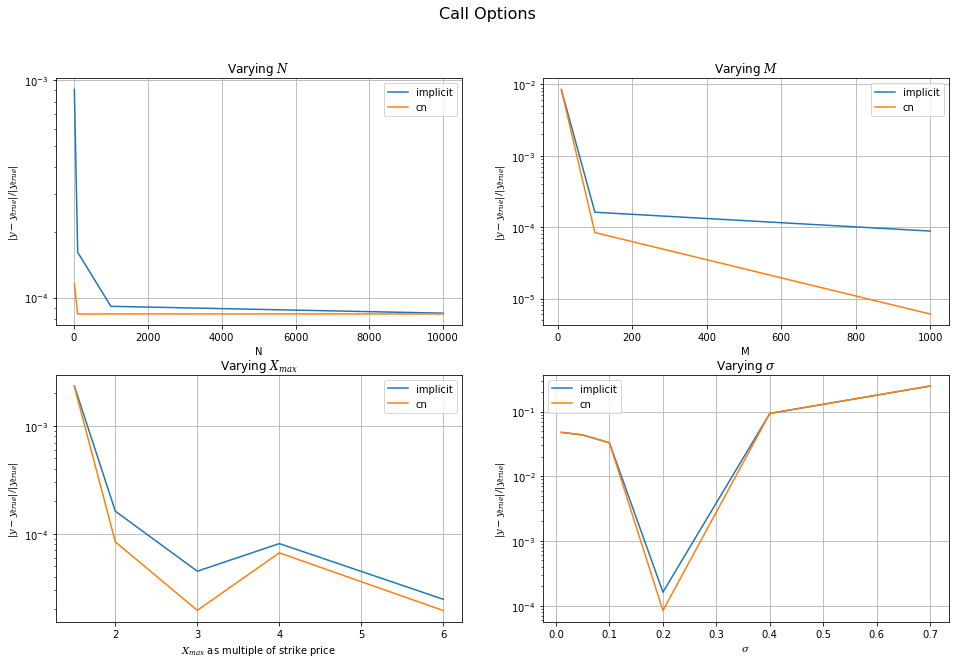

In [810]:
from tqdm import tqdm
params = {'X_min':0, 'X_max':100, 'r':0.02, 'strike':50, 'sigma':0.2, 'M':100, 'N':100, 'T':1, 't':0, 'option':'call'}
prev_x = np.zeros(1)
N_points = [10, 100, 1000, 10000]
M_points = [10, 100, 1000]
X_max_values = [75, 100, 150, 200, 300]
volatility = [0.01, 0.05, 0.1, 0.2, 0.4, 0.7]
fig, axes = plt.subplots(2,2, figsize=(16,10))
for method in ['implicit', 'cn']:
    errors = []
    for N in tqdm(N_points):
        x, y = solve_bs(method, **override(params, N=N))
        if not np.array_equal(prev_x, x):
            prev_x = x
            y_true = bs_analytical(x=x, **params)
        errors.append(np.linalg.norm(y - y_true) / np.linalg.norm(y_true))
    axes[0,0].semilogy(N_points, errors, label=method)
    axes[0,0].set_xlabel('N')
    axes[0,0].set_title(r'Varying $N$')
    
    errors = []
    for M in tqdm(M_points):
        x, y = solve_bs(method, **override(params, M=M))
        if not np.array_equal(prev_x, x):
            prev_x = x
            y_true = bs_analytical(x=x, **params)
        errors.append(np.linalg.norm(y - y_true) / np.linalg.norm(y_true))
    axes[0,1].semilogy(M_points, errors, label=method)
    axes[0,1].set_xlabel('M')
    axes[0,1].set_title(r'Varying $M$')
    
    
    errors = []
    for X_max in tqdm(X_max_values):
        x, y = solve_bs(method, **override(params, X_max=X_max))
        if not np.array_equal(prev_x, x):
            prev_x = x
            y_true = bs_analytical(x=x, **params)
        errors.append(np.linalg.norm(y - y_true) / np.linalg.norm(y_true))
    axes[1,0].semilogy(np.array(X_max_values) / params['strike'], errors, label=method)
    axes[1,0].set_xlabel(r'$X_{max}$ as multiple of strike price')
    axes[1,0].set_title(r'Varying $X_{max}$')
    
    errors = []
    for sigma in tqdm(volatility):
        x, y = solve_bs(method, **override(params, sigma=sigma))
        if not np.array_equal(prev_x, x):
            prev_x = x
            y_true = bs_analytical(x=x, **params)
        errors.append(np.linalg.norm(y - y_true) / np.linalg.norm(y_true))
    axes[1,1].semilogy(volatility, errors, label=method)
    axes[1,1].set_xlabel(r'$\sigma$')
    axes[1,1].set_title(r'Varying $\sigma$')
    
for ax in axes.flatten():
    ax.grid()
    ax.legend()
    ax.set_ylabel(r'$|y-y_{true}|/|y_{true}|$')
fig.suptitle('Call Options', fontsize=16)
plt.show()

  0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-782-3986182ca862>:5: RuntimeWarning: divide by zero encountered in log
  return (np.log(x/strike) + (r + 0.5 * sigma**2)*(T-t))/(sigma*np.sqrt((T-t)))
<ipython-input-782-3986182ca862>:8: RuntimeWarning: divide by zero encountered in log
  return (np.log(x/strike) + (r - 0.5 * sigma**2)*(T-t))/(sigma*np.sqrt((T-t)))
  0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-782-3986182ca862>:5: RuntimeWarning: divide by zero encountered in log
  return (np.log(x/strike) + (r + 0.5 * sigma**2)*(T-t))/(sigma*np.sqrt((T-t)))
<ipython-input-782-3986182ca862>:8: RuntimeWarning: divide by zero encountered in log
  return (np.log(x/strike) + (r - 0.5 * sigma**2)*(T-t))/(sigma*np.sqrt((T-t)))
  0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-782-3986182ca862>:5: RuntimeWarning: divide by zero encountered in log
  return (np.log(x/strike) + (r + 0.5 * sigma**2)*(T-t))/(sigma*np.sqrt((T-t)))
<ipython-input-782-3986182ca862>:8: RuntimeWarning: divide 

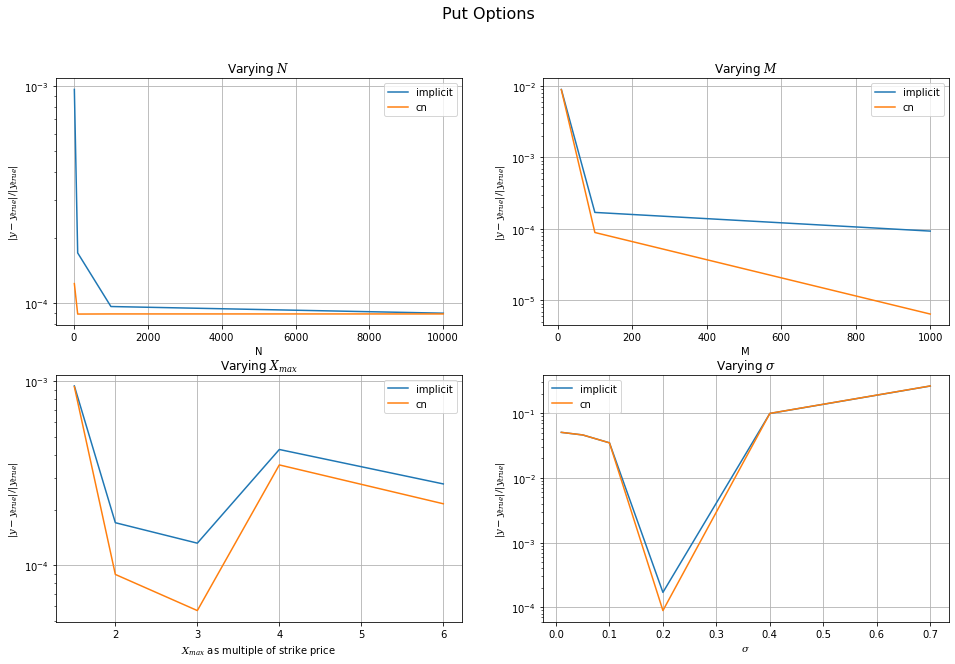

In [814]:
params = {'X_min':0, 'X_max':100, 'r':0.02, 'strike':50, 'sigma':0.2, 'M':100, 'N':100, 'T':1, 't':0, 'option':'put'}
prev_x = np.zeros(1)
N_points = [10, 100, 1000, 10000]
M_points = [10, 100, 1000]
X_max_values = [75, 100, 150, 200, 300]
volatility = [0.01, 0.05, 0.1, 0.2, 0.4, 0.7]
fig, axes = plt.subplots(2,2, figsize=(16,10))
for method in ['implicit', 'cn']:
    errors = []
    for N in tqdm(N_points):
        x, y = solve_bs(method, **override(params, N=N))
        if not np.array_equal(prev_x, x):
            prev_x = x
            y_true = bs_analytical(x=x, **params)
        errors.append(np.linalg.norm(y - y_true) / np.linalg.norm(y_true))
    axes[0,0].semilogy(N_points, errors, label=method)
    axes[0,0].set_xlabel('N')
    axes[0,0].set_title(r'Varying $N$')
    
    errors = []
    for M in tqdm(M_points):
        x, y = solve_bs(method, **override(params, M=M))
        if not np.array_equal(prev_x, x):
            prev_x = x
            y_true = bs_analytical(x=x, **params)
        errors.append(np.linalg.norm(y - y_true) / np.linalg.norm(y_true))
    axes[0,1].semilogy(M_points, errors, label=method)
    axes[0,1].set_xlabel('M')
    axes[0,1].set_title(r'Varying $M$')
    
    
    errors = []
    for X_max in tqdm(X_max_values):
        x, y = solve_bs(method, **override(params, X_max=X_max))
        if not np.array_equal(prev_x, x):
            prev_x = x
            y_true = bs_analytical(x=x, **params)
        errors.append(np.linalg.norm(y - y_true) / np.linalg.norm(y_true))
    axes[1,0].semilogy(np.array(X_max_values) / params['strike'], errors, label=method)
    axes[1,0].set_xlabel(r'$X_{max}$ as multiple of strike price')
    axes[1,0].set_title(r'Varying $X_{max}$')
    
    errors = []
    for sigma in tqdm(volatility):
        x, y = solve_bs(method, **override(params, sigma=sigma))
        if not np.array_equal(prev_x, x):
            prev_x = x
            y_true = bs_analytical(x=x, **params)
        errors.append(np.linalg.norm(y - y_true) / np.linalg.norm(y_true))
    axes[1,1].semilogy(volatility, errors, label=method)
    axes[1,1].set_xlabel(r'$\sigma$')
    axes[1,1].set_title(r'Varying $\sigma$')
    
for ax in axes.flatten():
    ax.grid()
    ax.legend()
    ax.set_ylabel(r'$|y-y_{true}|/|y_{true}|$')
fig.suptitle('Put Options', fontsize=16)
plt.show()

As we can see, the explicit method may experience oscillations and not be as stable. 

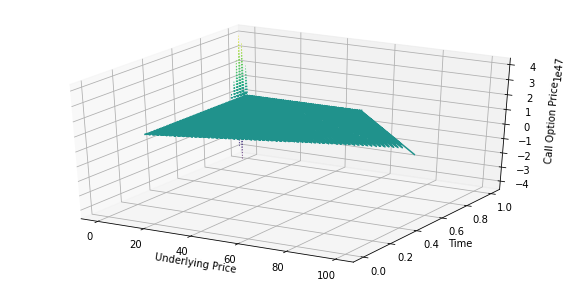

In [817]:
solver = ExplicitSolver(**params)
solver.solve()
fig = plt.figure()
ax = plt.axes(projection='3d')
X, Y = np.meshgrid(solver.X_space, solver.T_space)
Z = solver.U
ax.contour3D(X, Y, Z, 50)
ax.set_xlabel('Underlying Price')
ax.set_ylabel('Time')
ax.set_zlabel('Put Option Price');

TODO: stability, convergence, consistency?